In [5]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
from util.fft import *
from util.phantom import * 
from util.rank import *
import util.io as io
import random
import util.mask as undersample
from numpy import linalg as linalg

In [6]:
filepath = '../lib/resource/data/multicoil_1slice/meas_MID308_low_res_2dflash_FID17297.dat'
data = io.getCoilData(filepath) 
[ny, nx, nc] = data.shape
cmap = inati_cmap(ifft2c(data))
cmap = np.swapaxes(cmap, 2, 0)
data = np.swapaxes(data, 2, 0)
mask = np.zeros([ny, nx])
mask[:,0:ny:4]=1
mask[:,140:180]=1
data = data * np.tile(mask.reshape(1,ny,nx), (nc,1,1))

pymapVBVD version 0.4.8
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

read data:   0%|          | 0/256 [00:00<?, ?it/s]

In [7]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg import CG, FISTA, POGM, power_iter, FBPD
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dgram, Diff3dgram, Gmri, Wavelet2D, Diffnd
from mirtorch.prox import Prox, L1Regularizer, Const
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(data).to(device0).to(torch.complex64)
# Sense map
s_c = torch.tensor(cmap).to(device0).to(torch.complex64)
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Coil-wise iFFT reconstruction and central crop
I1 = (Fop.H*k_c).to(torch.complex64).unsqueeze(0)
nx = 256
ny = 256
I1 = I1[:,:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2]
s_c = s_c[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2].unsqueeze(0).to(torch.complex64)
# simulate the cropped k-space


mask = np.ones([nc, ny, nx])
mask[np.abs(k_c) == 0] = 0
mask = np.sum(mask, 0)
mask = mask.astype("float32")
mask = torch.tensor(mask).to(device0)

Fop = FFTCn((1, nc, nx, ny), (1, nc, nx, ny), (2,3), norm = 'ortho')
K1 = Fop*I1
# A'y
Sop = Sense(s_c, mask.unsqueeze(0))
I0 = Sop.H*K1

In [11]:
# Define the wavelet operator
W = Wavelet2D(I0.shape, padding='periodization', J=2, wave_type = 'db4')
# Calculate the step size with power iteration (Lipschitz)
L = power_iter(Sop, torch.randn_like(I0), max_iter=200)
# Define the proximal operator
wv_weights = 1e-5
P = L1Regularizer(wv_weights, T = W)
# Define the gradient
def gradA(x):
    return Sop.H*Sop*x-I0

# Record the curve of loss function
def evalation(x):
    return (torch.norm(Sop*x-K1)**2).item()+wv_weights*torch.norm(P(x,1), p=1).item()

The calculation of max singular value accomplished at 76 iterations.
The spectral norm is 31.976381301879883.


In [12]:
# POGM
start = time.time()
[pg_wavelet, loss_pg_wavelet] = POGM(f_grad=gradA, f_L=L[1].item()**2, g_prox=P, max_iter=100, eval_func=evalation).run(x0=I0)
print('running time %f s'%(time.time()-start))

running time 17.975544 s


In [18]:
start = time.time()
[fs_wavelet, loss_fs_wavelet] = FISTA(f_grad=gradA, f_L=L[1].item()**2, g_prox=P, max_iter=100, eval_func=evalation).run(x0=I0)
print('running time %f s'%(time.time()-start))

running time 11.970935 s


In [19]:
f_prox = Const()
start = time.time()
[fbpd_wavelet, loss_fbpd_wavelet] = FBPD(gradA, f_prox, P, L[1].item()**2, 1, G=W, max_iter=200, eval_func=evalation).run(torch.zeros_like(I0))
print('running time %f s'%(time.time()-start))

running time 28.428124 s


In [20]:
TV_weight = 1e-4
T = Diffnd(I0.shape, [2,3])
P1 = L1Regularizer(TV_weight)
def evalation(x):
    return (torch.norm(Sop*x-K1)**2).item()+TV_weight*torch.norm(T*x, p=1).item()
f_prox = Const()
start = time.time()
[fbpd_tv, loss_fbpd_tv] = FBPD(gradA, f_prox, P1, L[1].item()**2, 8, G=T, max_iter=200, eval_func=evalation).run(I0)
print('running time %f s'%(time.time()-start))

running time 20.958069 s


Text(0.5, 1.0, 'FISTA-Wavelets Recon')

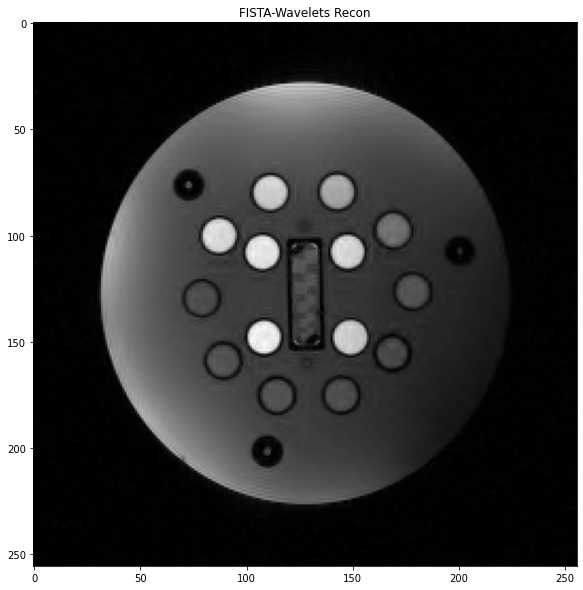

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fs_wavelet[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FISTA-Wavelets Recon')

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs((pg_wavelet[0,0,:,:])).cpu().data.numpy(),cmap='gray')
plt.title('POGM-Wavelets recon')

NameError: name 'pg_wavelet' is not defined

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'FBPD-Wavelets Recon')

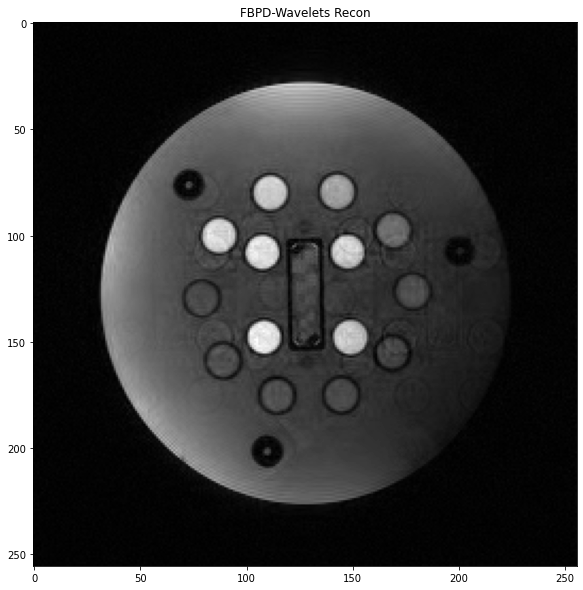

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fbpd_wavelet[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FBPD-Wavelets Recon')